In [3]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 42.5 MB/s eta 0:00:00


In [4]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00


In [5]:
# Import Dependencies
import torch
import torch.nn as nn


class ESPCN(nn.Module):
    def __init__(self, num_channels, scaling_factor):
        """ ESPCN Model class

        :param num_channels (int): Number of channels in input image
        :param scaling_factor (int): Factor to scale-up the input image by
        """

        super(ESPCN, self).__init__()

        # As per paper, 3 conv layers in backbone, adding padding is optional, not mentioned to use in paper
        # SRCNN paper does not recommend using padding, padding here just helps to visualize the scaled up output image
        # Extract input image feature maps
        self.feature_map_layer = nn.Sequential(
            # (f1,n1) = (5, 64)
            nn.Conv2d(in_channels=num_channels, kernel_size=(5, 5), out_channels=64, padding=(2, 2)),
            # Using "Tanh" activation instead of "ReLU"
            nn.Tanh(),
            # (f2,n2) = (3, 32)
            nn.Conv2d(in_channels=64, kernel_size=(3, 3), out_channels=32, padding=(1, 1)),
            # Using "Tanh" activation instead of "ReLU"
            nn.Tanh()
        )

        self.sub_pixel_layer = nn.Sequential(
            # f3 = 3, # output shape: H x W x (C x r**2)
            nn.Conv2d(in_channels=32, kernel_size=(3, 3), out_channels=num_channels * (scaling_factor ** 2), padding=(1, 1)),
            # Sub-Pixel Convolution Layer - PixelShuffle
            # rearranges: H x W x (C x r**2) => rH x rW x C
            nn.PixelShuffle(upscale_factor=scaling_factor)
        )

    def forward(self, x):
        """

        :param x: input image
        :return: model output
        """

        # inputs: H x W x C
        x = self.feature_map_layer(x)
        # output: rH x rW x C
        # r: scale_factor
        out = self.sub_pixel_layer(x)

        return out


In [7]:
import torch
import torch.onnx

model = ESPCN(num_channels=1, scaling_factor=3)

# Load the pre-trained model state dictionary
model_state_dict = torch.load('/content/drive/MyDrive/RTSR/model_assets/epoch_24.pth', map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
model.eval()

# Define the input size
input_size = (1, 1, 240, 480)

# Create a dummy input
dummy_input = torch.randn(input_size, requires_grad=True)

# Export the model to ONNX format
torch.onnx.export(
    model,
    dummy_input,
    "24_ep.onnx",
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    opset_version=11
)

## check inference and time taken

In [8]:
import numpy as np

In [9]:
import onnx
import onnxruntime

# Load the ONNX model
onnx_model = onnx.load("/content/24_ep.onnx")

In [10]:
# Validate the ONNX model
onnx.checker.check_model(onnx_model)

In [11]:
# Create an ONNX runtime session
ort_session = onnxruntime.InferenceSession("/content/24_ep.onnx")

In [12]:
# Assuming your input has shape (1, 1, 224, 224)
input_data_test = np.random.randn(1, 1, 240, 480).astype(np.float32)

In [19]:
import time

# Run inference and measure the time
start_time = time.time()
ort_outputs = ort_session.run(None, {"input": input_data_test})
inference_time = time.time() - start_time

print(f"Inference time: {inference_time:.4f} seconds")

Inference time: 0.1066 seconds


## trying to optimize onnxruntime

In [20]:
from onnxruntime.transformers import optimizer
from PIL import Image

In [21]:
optimized_model = optimizer.optimize_model("/content/24_ep.onnx")

In [22]:
onnx.save(optimized_model.model, "24_ep_optimized.onnx")

In [23]:
ort_session = onnxruntime.InferenceSession("/content/24_ep_optimized.onnx")

In [27]:
# Run inference and measure the time
start_time = time.time()
ort_outputs = ort_session.run(None, {"input": input_data_test})
inference_time = time.time() - start_time

print(f"Inference time: {inference_time:.4f} seconds")

Inference time: 0.1433 seconds


In [26]:
output_tensor = ort_outputs[0]
output_tensor = np.squeeze(output_tensor)  # Remove the extra dimensions
output_tensor = np.clip(output_tensor, 0, 1)  # Ensure values are in the range [0, 1]
output_tensor = (output_tensor * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

# Save the output as a PNG file
output_image = Image.fromarray(output_tensor)
output_image.save("output.png")


## trying an actual image

In [28]:
import cv2


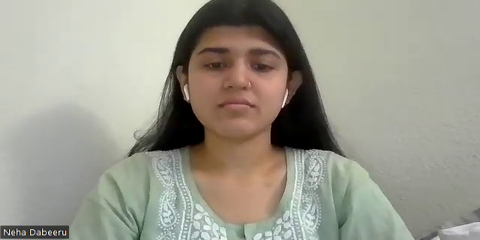

In [81]:
input_image

In [29]:
image_path = '/content/drive/MyDrive/RTSR/collected_combined_frames_3/Neha_frame_0021.png'
input_image = Image.open(image_path)
input_image = input_image.resize((480, 240), resample=Image.BICUBIC)

In [38]:
lr_image = np.array(input_image).astype(np.float32)

In [54]:
lr_image_1 = np.array(input_image).astype(np.float32)

In [39]:
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_RGB2YCrCb)

In [40]:
lr_y = lr_image[:, :, 0]

In [41]:
lr_y /= 255.

In [42]:
lr_y = np.expand_dims(np.expand_dims(lr_y, axis=0), axis=0)

In [43]:
lr_y

array([[[[0.79132944, 0.79132944, 0.79132944, ..., 0.68544704,
          0.6776039 , 0.67368233],
         [0.79132944, 0.79132944, 0.79132944, ..., 0.68544704,
          0.6776039 , 0.6776039 ],
         [0.79132944, 0.79132944, 0.79132944, ..., 0.68544704,
          0.68152547, 0.6776039 ],
         ...,
         [0.3877647 , 0.2318196 , 0.23621176, ..., 0.62352943,
          0.61960787, 0.627451  ],
         [0.49040785, 0.3891294 , 0.38657257, ..., 0.62352943,
          0.627451  , 0.627451  ],
         [0.69690984, 0.6961843 , 0.6825216 , ..., 0.627451  ,
          0.627451  , 0.627451  ]]]], dtype=float32)

In [45]:
start_time = time.time()
ort_outputs = ort_session.run(None, {"input": lr_y})
inference_time = time.time() - start_time

print(f"Inference time: {inference_time:.4f} seconds")

Inference time: 0.1184 seconds


In [46]:
ort_outputs

[array([[[[0.7957097 , 0.7962601 , 0.7938554 , ..., 0.6761855 ,
           0.6751026 , 0.67627764],
          [0.79437506, 0.79289734, 0.79148555, ..., 0.6684841 ,
           0.6721208 , 0.6753721 ],
          [0.7908262 , 0.7913238 , 0.7917166 , ..., 0.6706184 ,
           0.6747235 , 0.67805636],
          ...,
          [0.6856172 , 0.6849759 , 0.6829848 , ..., 0.6244191 ,
           0.62476826, 0.6286963 ],
          [0.7033264 , 0.69376194, 0.68327224, ..., 0.6255613 ,
           0.62729216, 0.6309649 ],
          [0.74116945, 0.7126615 , 0.6772602 , ..., 0.62897635,
           0.6311395 , 0.62847286]]]], dtype=float32)]

In [47]:
y_channel = ort_outputs[0]
upscaled_y = (y_channel * 255).astype(np.uint8).squeeze()

In [61]:
upscaled_y.shape

(720, 1440)

In [64]:
lr_image[0]

(240, 480, 3)

In [59]:
lr_image[:, :, 1]

array([[ 0.65044194,  0.65044194,  0.65044194, ...,  0.65044194,
         0.65044194,  0.65044194],
       [ 0.65044194,  0.65044194,  0.65044194, ...,  0.65044194,
         0.65044194,  0.65044194],
       [ 0.65044194,  0.65044194,  0.65044194, ...,  0.65044194,
         0.65044194,  0.65044194],
       ...,
       [ 2.0115619 ,  0.41871914, -1.0928428 , ...,  0.5       ,
         0.5       ,  0.5       ],
       [ 1.1744974 ,  0.33743826, -1.3366909 , ...,  0.5       ,
         0.5       ,  0.5       ],
       [ 1.41834   ,  0.8372541 , -0.24365848, ...,  0.5       ,
         0.5       ,  0.5       ]], dtype=float32)

In [69]:
lr_image[0]

array([[ 0.79132944,  0.65044194, -3.328997  ],
       [ 0.79132944,  0.65044194, -3.328997  ],
       [ 0.79132944,  0.65044194, -3.328997  ],
       ...,
       [ 0.68544704,  0.65044194, -3.328997  ],
       [ 0.6776039 ,  0.65044194, -3.328997  ],
       [ 0.67368233,  0.65044194, -3.328997  ]], dtype=float32)

In [70]:
# If lr_image is a NumPy array representing the image, then you get its height and width like this:
height, width = lr_image.shape[:2]  # This assumes that lr_image has at least 2 dimensions

# Now, you can use these dimensions to calculate the size for bicubic interpolation
bicubic_interpolated_size = (width * 3, height * 3)  # Triple the width and height for 3x upscaling

# Use the calculated size to resize the input_image using bicubic interpolation
bicubic_interpolated_RGB = input_image.resize(bicubic_interpolated_size, resample=Image.BICUBIC)

In [75]:
bicubic_interpolated_RGB = np.array(bicubic_interpolated_RGB).astype(np.float32)

In [76]:
bicubic_interpolated_ycrcb = cv2.cvtColor(bicubic_interpolated_RGB, cv2.COLOR_RGB2YCrCb)

In [77]:
output = np.array([upscaled_y, bicubic_interpolated_ycrcb[..., 1], bicubic_interpolated_ycrcb[..., 2]]).transpose([1, 2, 0])

In [78]:
output = np.clip(cv2.cvtColor(output, cv2.COLOR_YCrCb2RGB), 0.0, 255.0).astype(np.uint8)

In [79]:
output = Image.fromarray(output)

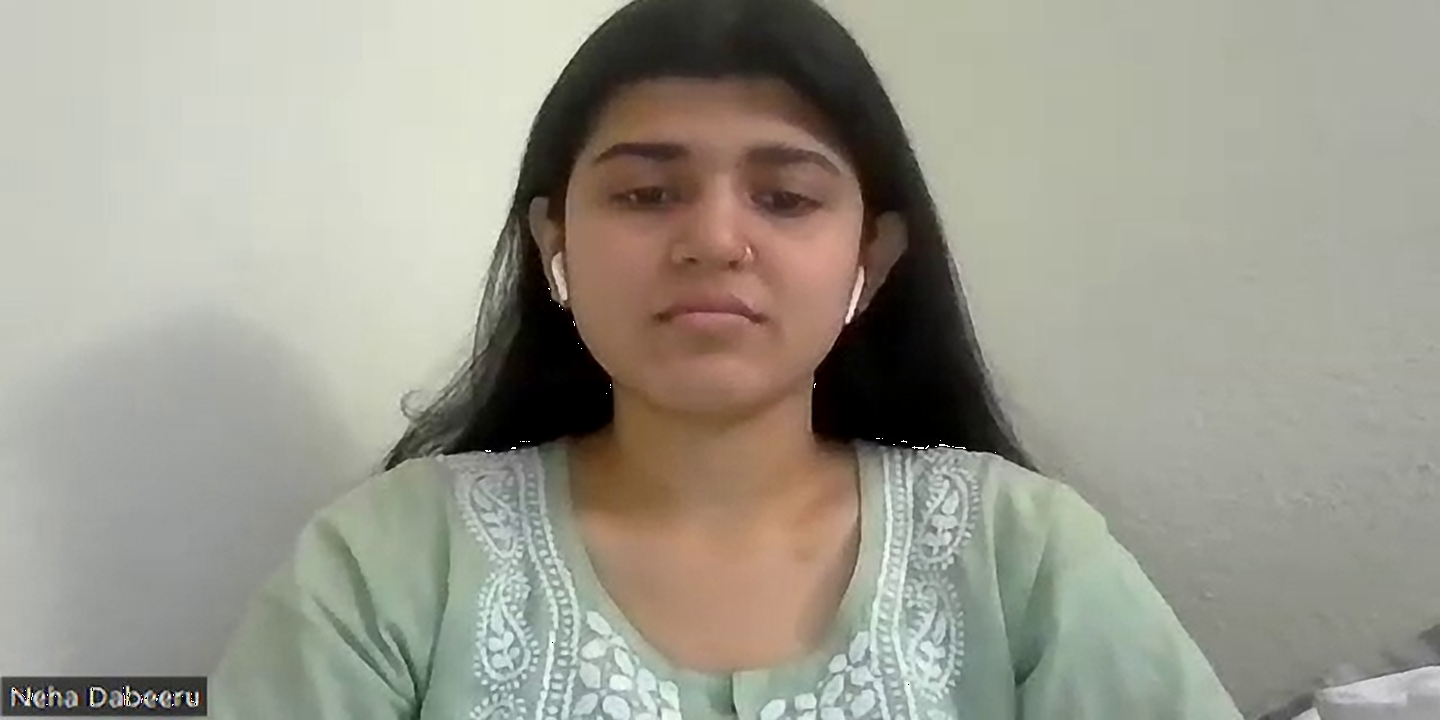

In [80]:
output

In [ ]:
def sender(image):
  frame = Image.open(image_path)
  frame = frame.resize((480, 240), resample=Image.BICUBIC)
  return frame

'''def encode(frame) '''

def receiver(frame):
  frame = Image.open(frame)

  lr_image = np.array(frame).astype(np.float32)

  height, width = lr_image.shape[:2]
  bicubic_interpolated_size = (width * 3, height * 3)
  bicubic_interpolated_RGB = input_image.resize(bicubic_interpolated_size, resample=Image.BICUBIC)
  bicubic_interpolated_RGB = np.array(bicubic_interpolated_RGB).astype(np.float32)

  lr_image_ycrcb = cv2.cvtColor(lr_image, cv2.COLOR_RGB2YCrCb)
  bicubic_interpolated_ycrcb = cv2.cvtColor(bicubic_interpolated_RGB, cv2.COLOR_RGB2YCrCb)

  lr_y = lr_image_ycrcb[:, :, 0]
  lr_y /= 255.
  lr_y = np.expand_dims(np.expand_dims(lr_y, axis=0), axis=0)

  ort_session = onnxruntime.InferenceSession("/content/24_ep_optimized.onnx")
  ort_outputs = ort_session.run(None, {"input": lr_y})

  y_channel = ort_outputs[0]
  upscaled_y = (y_channel * 255).astype(np.uint8).squeeze()

  output = np.array([upscaled_y, bicubic_interpolated_ycrcb[..., 1], bicubic_interpolated_ycrcb[..., 2]]).transpose([1, 2, 0])

